In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
SEED = 999

In [2]:
#==============================================================================
# Data Processing
#==============================================================================
df = pd.read_csv('dermatology.data', header=None)
df.columns = [
    "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13", 
    "V14", "V15", "V16", "V17", "V18", "V19", "V20", "V21", "V22", "V23", "V24", 
    "V25", "V26", "V27", "V28", "V29", "V30", "V31", "V32", "V33", "V34", "Class"]

In [3]:
df[df['V34'] == '?'].head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
33,2,2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,?,1
34,2,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,?,4
35,2,2,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,?,2


In [4]:
df = df.replace('?', 0)

In [5]:
X = df.loc[:,: 'V34']
y = df['Class']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [6]:
# Функция пригодности подмножества функций
def getFitness(individual, X_train, X_test, y_train, y_test):

    # Разбор столбцов объектов, которые мы не используем
    # Применение OneHotEncoder к функциям
    cols = [index for index in range(len(individual)) if individual[index] == 0]
    X_trainParsed = X_train.drop(X_train.columns[cols], axis=1)
    X_trainOhFeatures = pd.get_dummies(X_trainParsed)
    X_testParsed = X_test.drop(X_test.columns[cols], axis=1)
    X_testOhFeatures = pd.get_dummies(X_testParsed)

    # Удаление всех столбцов, отсутствующих в тренировочном и тестовом наборах данных
    sharedFeatures = set(X_trainOhFeatures.columns) & set(X_testOhFeatures.columns)
    removeFromTrain = set(X_trainOhFeatures.columns) - sharedFeatures
    removeFromTest = set(X_testOhFeatures.columns) - sharedFeatures
    X_trainOhFeatures = X_trainOhFeatures.drop(list(removeFromTrain), axis=1)
    X_testOhFeatures = X_testOhFeatures.drop(list(removeFromTest), axis=1)

    # Применение логистической регрессии к данным и рассчитывание точности
    clf = SVC(kernel="linear") # это убрать
    #clf = LogisticRegression(solver='lbfgs', multi_class='ovr')
    clf.fit(X_trainOhFeatures, y_train)
    predictions = clf.predict(X_testOhFeatures)
    accuracy = accuracy_score(y_test, predictions)

    # Возвращенная вычисленная точность как пригодность
    return (accuracy,)

In [7]:
#==============================================================================
# Create interactions and standarize
#==============================================================================
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Interaction terms
poly = PolynomialFeatures(degree=2)
X_train = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names(X.columns))
X_test = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names(X.columns))
# Standardize data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [8]:
import scipy.stats as stats
import sklearn
import keras
import imblearn
import seaborn as sns
plt.style.use('ggplot')
# reading in CSV
df.sample(5)

Using TensorFlow backend.


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V26,V27,V28,V29,V30,V31,V32,V33,V34,Class
226,1,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,35,5
41,1,1,1,0,0,0,0,0,0,0,...,0,0,2,0,0,0,2,0,62,4
46,2,1,1,3,3,0,0,0,0,0,...,0,0,1,0,0,0,2,0,46,4
10,3,3,2,1,1,0,0,0,2,2,...,0,0,0,0,0,0,1,0,20,1
197,3,2,2,0,0,0,0,0,0,0,...,0,0,2,0,0,0,2,0,50,2


Text(0.5, 1.0, 'Class')

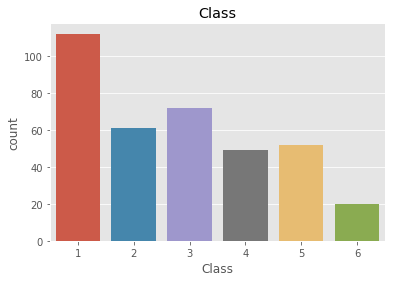

In [9]:
sns.countplot('Class', data = df)
plt.title('Class')

Test Accuracy 0.9324324324324325


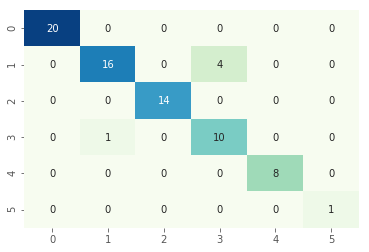

In [10]:
#==============================================================================
# All features
#==============================================================================
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

# Fit Logistic Features to all features
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)

# Test accuracy
acc = accuracy_score(y_test, svc.predict(X_test))
print('Test Accuracy {}'.format(acc))

# Plot confusion matrix
cm = confusion_matrix(y_test, svc.predict(X_test))
sns.heatmap(cm, fmt='d', cmap='GnBu', cbar=False, annot=True)

Number of features selected: 65
Test Accuracy 0.9594594594594594


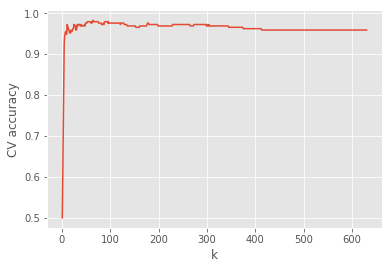

In [11]:
#==============================================================================
# Recursive Feature Selection
#==============================================================================
from sklearn.feature_selection import RFECV

# RFE
rfe = RFECV(estimator=SVC(kernel="linear"), cv=4, scoring='accuracy')
rfe = rfe.fit(X_train, y_train)

# Select variables and calulate test accuracy
cols = X_train.columns[rfe.support_]
acc = accuracy_score(y_test, rfe.estimator_.predict(X_test[cols]))
print('Number of features selected: {}'.format(rfe.n_features_))
print('Test Accuracy {}'.format(acc))

# Plot number of features vs CV scores
plt.figure()
plt.xlabel('k')
plt.ylabel('CV accuracy')
plt.plot(np.arange(1, rfe.grid_scores_.size+1), rfe.grid_scores_)
plt.show()

In [12]:
#==============================================================================
# Feature importances
#==============================================================================
from sklearn.ensemble import RandomForestClassifier

# Feature importance values from Random Forests
rf = RandomForestClassifier(n_jobs=-1, random_state=SEED)
rf.fit(X_train, y_train)
feat_imp = rf.feature_importances_

# Select features and fit Logistic Regression
cols = X_train.columns[feat_imp >= 0.01]
est_imp = SVC(kernel="linear")
est_imp.fit(X_train[cols], y_train)

# Test accuracy
acc = accuracy_score(y_test, est_imp.predict(X_test[cols]))
print('Number of features selected: {}'.format(len(cols)))
print('Test Accuracy {}'.format(acc))

C:\D\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Number of features selected: 32
Test Accuracy 0.9594594594594594


In [13]:
#==============================================================================
# Boruta
#==============================================================================
from boruta import BorutaPy

# Random Forests for Boruta 
rf_boruta = RandomForestClassifier(n_jobs=-1, random_state=SEED)
# Perform Boruta
boruta = BorutaPy(rf_boruta, n_estimators='auto', verbose=2)
boruta.fit(X_train.values, y_train.values.ravel())

# Select features and fit Logistic Regression
cols = X_train.columns[boruta.support_]
est_boruta = SVC(kernel="linear")
est_boruta.fit(X_train[cols], y_train)

# Test accuracy
acc = accuracy_score(y_test, est_boruta.predict(X_test[cols]))
print('Number of features selected: {}'.format(len(cols)))
print('Test Accuracy {}'.format(acc))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	177
Tentative: 	150
Rejected: 	303
Iteration: 	9 / 100
Confirmed: 	177
Tentative: 	150
Rejected: 	303
Iteration: 	10 / 100
Confirmed: 	177
Tentative: 	150
Rejected: 	303
Iteration: 	11 / 100
Confirmed: 	177
Tentative: 	150
Rejected: 	303
Iteration: 	12 / 100
Confirmed: 	185
Tentative: 	142
Rejected: 	303
Iteration: 	13 / 100
Confirmed: 	185
Tentative: 	122
Rejected: 	323
Iteration: 	14 / 100
Confirmed: 	185
Tentative: 	122
Rejected: 	323
Iteration: 	15 / 100
Confirmed: 	185
Tentative: 	122
Rejected: 	323
Iteration: 	16 / 

In [14]:
from imblearn.over_sampling import RandomOverSampler
# random oversampling
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# using Counter to display results of naive oversampling
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(1, 92), (2, 92), (3, 92), (4, 92), (5, 92), (6, 92)]


In [15]:
X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)
y_resampled = pd.DataFrame(y_resampled, columns=['Class'])

Test Accuracy 0.9324324324324325


C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


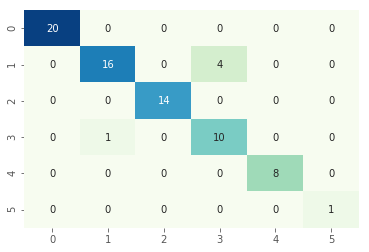

In [16]:
# Fit Logistic Features to all features
svc = SVC(kernel="linear")
svc.fit(X_resampled, y_resampled)

# Test accuracy
acc = accuracy_score(y_test, svc.predict(X_test))
print('Test Accuracy {}'.format(acc))

# Plot confusion matrix
cm = confusion_matrix(y_test, svc.predict(X_test))
sns.heatmap(cm, fmt='d', cmap='GnBu', cbar=False, annot=True)

C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of features selected: 44
Test Accuracy 0.9459459459459459


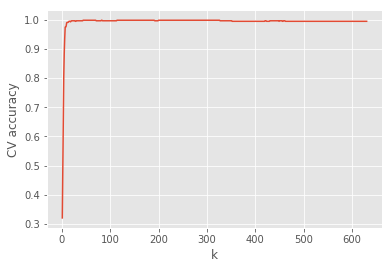

In [17]:
#==============================================================================
# Recursive Feature Selection
#==============================================================================

# RFE
rfe = RFECV(estimator=SVC(kernel="linear"), cv=4, scoring='accuracy')
rfe = rfe.fit(X_resampled, y_resampled)

# Select variables and calulate test accuracy
cols = X_resampled.columns[rfe.support_]
acc = accuracy_score(y_test, rfe.estimator_.predict(X_test[cols]))
print('Number of features selected: {}'.format(rfe.n_features_))
print('Test Accuracy {}'.format(acc))

# Plot number of features vs CV scores
plt.figure()
plt.xlabel('k')
plt.ylabel('CV accuracy')
plt.plot(np.arange(1, rfe.grid_scores_.size+1), rfe.grid_scores_)
plt.show()

In [18]:
#==============================================================================
# Feature importances
#==============================================================================

# Feature importance values from Random Forests
rf = RandomForestClassifier(n_jobs=-1, random_state=SEED)
rf.fit(X_resampled, y_resampled)
feat_imp = rf.feature_importances_

# Select features and fit Logistic Regression
cols = X_resampled.columns[feat_imp >= 0.01]
est_imp = SVC(kernel="linear")
est_imp.fit(X_resampled[cols], y_resampled)

# Test accuracy
acc = accuracy_score(y_test, est_imp.predict(X_test[cols]))
print('Number of features selected: {}'.format(len(cols)))
print('Test Accuracy {}'.format(acc))

C:\D\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Number of features selected: 44
Test Accuracy 0.9864864864864865


C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [19]:
#==============================================================================
# Boruta
#==============================================================================

# Random Forests for Boruta 
rf_boruta = RandomForestClassifier(n_jobs=-1, random_state=SEED)
# Perform Boruta
boruta = BorutaPy(rf_boruta, n_estimators='auto', verbose=2)
boruta.fit(X_resampled.values, y_resampled.values.ravel())

# Select features and fit Logistic Regression
cols = X_resampled.columns[boruta.support_]
est_boruta = SVC(kernel="linear")
est_boruta.fit(X_resampled[cols], y_resampled)

# Test accuracy
acc = accuracy_score(y_test, est_boruta.predict(X_test[cols]))
print('Number of features selected: {}'.format(len(cols)))
print('Test Accuracy {}'.format(acc))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	246
Tentative: 	141
Rejected: 	243
Iteration: 	9 / 100
Confirmed: 	246
Tentative: 	141
Rejected: 	243
Iteration: 	10 / 100
Confirmed: 	246
Tentative: 	141
Rejected: 	243
Iteration: 	11 / 100
Confirmed: 	246
Tentative: 	141
Rejected: 	243
Iteration: 	12 / 100
Confirmed: 	257
Tentative: 	130
Rejected: 	243
Iteration: 	13 / 100
Confirmed: 	257
Tentative: 	130
Rejected: 	243
Iteration: 	14 / 100
Confirmed: 	257
Tentative: 	119
Rejected: 	254
Iteration: 	15 / 100
Confirmed: 	257
Tentative: 	119
Rejected: 	254
Iteration: 	16 / 

C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
from imblearn.over_sampling import SMOTE
# applying SMOTE to our data and checking the class counts
X_resampled1, y_resampled1 = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled1).items()))

[(1, 92), (2, 92), (3, 92), (4, 92), (5, 92), (6, 92)]


In [21]:
X_resampled1 = pd.DataFrame(X_resampled1, columns=X_train.columns)
y_resampled1 = pd.DataFrame(y_resampled1, columns=['Class'])

Test Accuracy 0.9324324324324325


C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


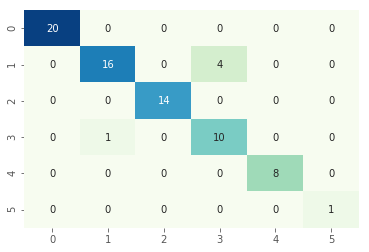

In [22]:
# Fit Logistic Features to all features
svc = SVC(kernel="linear")
svc.fit(X_resampled1, y_resampled1)

# Test accuracy
acc = accuracy_score(y_test, svc.predict(X_test))
print('Test Accuracy {}'.format(acc))

# Plot confusion matrix
cm = confusion_matrix(y_test, svc.predict(X_test))
sns.heatmap(cm, fmt='d', cmap='GnBu', cbar=False, annot=True)

C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of features selected: 68
Test Accuracy 0.9594594594594594


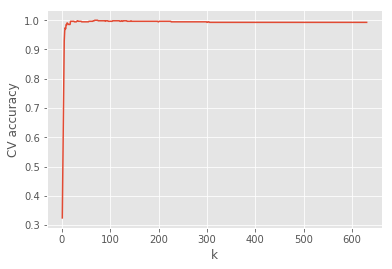

In [23]:
#==============================================================================
# Recursive Feature Selection
#==============================================================================

# RFE
rfe = RFECV(estimator=SVC(kernel="linear"), cv=4, scoring='accuracy')
rfe = rfe.fit(X_resampled1, y_resampled1)

# Select variables and calulate test accuracy
cols = X_resampled1.columns[rfe.support_]
acc = accuracy_score(y_test, rfe.estimator_.predict(X_test[cols]))
print('Number of features selected: {}'.format(rfe.n_features_))
print('Test Accuracy {}'.format(acc))

# Plot number of features vs CV scores
plt.figure()
plt.xlabel('k')
plt.ylabel('CV accuracy')
plt.plot(np.arange(1, rfe.grid_scores_.size+1), rfe.grid_scores_)
plt.show()

In [24]:
#==============================================================================
# Feature importances
#==============================================================================

# Feature importance values from Random Forests
rf = RandomForestClassifier(n_jobs=-1, random_state=SEED)
rf.fit(X_resampled1, y_resampled1)
feat_imp = rf.feature_importances_

# Select features and fit Logistic Regression
cols = X_resampled1.columns[feat_imp >= 0.01]
est_imp = SVC(kernel="linear")
est_imp.fit(X_resampled1[cols], y_resampled1)

# Test accuracy
acc = accuracy_score(y_test, est_imp.predict(X_test[cols]))
print('Number of features selected: {}'.format(len(cols)))
print('Test Accuracy {}'.format(acc))

C:\D\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Number of features selected: 42
Test Accuracy 0.9594594594594594


C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
#==============================================================================
# Boruta
#==============================================================================

# Random Forests for Boruta 
rf_boruta = RandomForestClassifier(n_jobs=-1, random_state=SEED)
# Perform Boruta
boruta = BorutaPy(rf_boruta, n_estimators='auto', verbose=2)
boruta.fit(X_resampled1.values, y_resampled1.values.ravel())

# Select features and fit Logistic Regression
cols = X_resampled1.columns[boruta.support_]
est_boruta = SVC(kernel="linear")
est_boruta.fit(X_resampled1[cols], y_resampled1)

# Test accuracy
acc = accuracy_score(y_test, est_boruta.predict(X_test[cols]))
print('Number of features selected: {}'.format(len(cols)))
print('Test Accuracy {}'.format(acc))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	233
Tentative: 	151
Rejected: 	246
Iteration: 	9 / 100
Confirmed: 	233
Tentative: 	151
Rejected: 	246
Iteration: 	10 / 100
Confirmed: 	233
Tentative: 	151
Rejected: 	246
Iteration: 	11 / 100
Confirmed: 	233
Tentative: 	151
Rejected: 	246
Iteration: 	12 / 100
Confirmed: 	245
Tentative: 	139
Rejected: 	246
Iteration: 	13 / 100
Confirmed: 	245
Tentative: 	117
Rejected: 	268
Iteration: 	14 / 100
Confirmed: 	245
Tentative: 	117
Rejected: 	268
Iteration: 	15 / 100
Confirmed: 	245
Tentative: 	117
Rejected: 	268
Iteration: 	16 / 

C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
from imblearn.over_sampling import ADASYN
# applying ADASYN
X_resampled2, y_resampled2 = ADASYN().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled2).items()))

[(1, 92), (2, 89), (3, 92), (4, 96), (5, 91), (6, 91)]


In [27]:
X_resampled2 = pd.DataFrame(X_resampled2, columns=X_train.columns)
y_resampled2 = pd.DataFrame(y_resampled2, columns=['Class'])

Test Accuracy 0.9324324324324325


C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


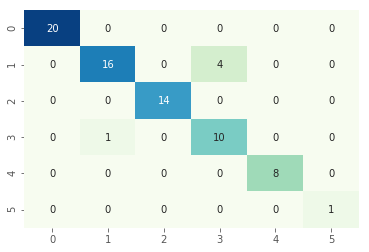

In [28]:
# Fit Logistic Features to all features
svc = SVC(kernel="linear")
svc.fit(X_resampled2, y_resampled2)

# Test accuracy
acc = accuracy_score(y_test, svc.predict(X_test))
print('Test Accuracy {}'.format(acc))

# Plot confusion matrix
cm = confusion_matrix(y_test, svc.predict(X_test))
sns.heatmap(cm, fmt='d', cmap='GnBu', cbar=False, annot=True)

C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of features selected: 44
Test Accuracy 0.9459459459459459


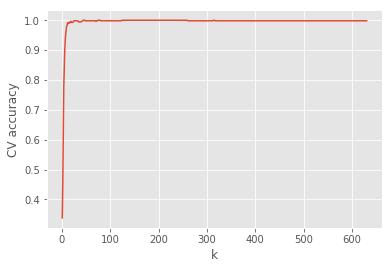

In [29]:
#==============================================================================
# Recursive Feature Selection
#==============================================================================

# RFE
rfe = RFECV(estimator=SVC(kernel="linear"), cv=4, scoring='accuracy')
rfe = rfe.fit(X_resampled2, y_resampled2)

# Select variables and calulate test accuracy
cols = X_resampled2.columns[rfe.support_]
acc = accuracy_score(y_test, rfe.estimator_.predict(X_test[cols]))
print('Number of features selected: {}'.format(rfe.n_features_))
print('Test Accuracy {}'.format(acc))

# Plot number of features vs CV scores
plt.figure()
plt.xlabel('k')
plt.ylabel('CV accuracy')
plt.plot(np.arange(1, rfe.grid_scores_.size+1), rfe.grid_scores_)
plt.show()

In [30]:
#==============================================================================
# Feature importances
#==============================================================================

# Feature importance values from Random Forests
rf = RandomForestClassifier(n_jobs=-1, random_state=SEED)
rf.fit(X_resampled2, y_resampled2)
feat_imp = rf.feature_importances_

# Select features and fit Logistic Regression
cols = X_resampled2.columns[feat_imp >= 0.01]
est_imp = SVC(kernel="linear")
est_imp.fit(X_resampled2[cols], y_resampled2)

# Test accuracy
acc = accuracy_score(y_test, est_imp.predict(X_test[cols]))
print('Number of features selected: {}'.format(len(cols)))
print('Test Accuracy {}'.format(acc))

C:\D\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Number of features selected: 40
Test Accuracy 0.9594594594594594


C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
#==============================================================================
# Boruta
#==============================================================================

# Random Forests for Boruta 
rf_boruta = RandomForestClassifier(n_jobs=-1, random_state=SEED)
# Perform Boruta
boruta = BorutaPy(rf_boruta, n_estimators='auto', verbose=2)
boruta.fit(X_resampled2.values, y_resampled2.values.ravel())

# Select features and fit Logistic Regression
cols = X_resampled2.columns[boruta.support_]
est_boruta = SVC(kernel="linear")
est_boruta.fit(X_resampled2[cols], y_resampled2)

# Test accuracy
acc = accuracy_score(y_test, est_boruta.predict(X_test[cols]))
print('Number of features selected: {}'.format(len(cols)))
print('Test Accuracy {}'.format(acc))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	237
Tentative: 	150
Rejected: 	243
Iteration: 	9 / 100
Confirmed: 	237
Tentative: 	150
Rejected: 	243
Iteration: 	10 / 100
Confirmed: 	237
Tentative: 	150
Rejected: 	243
Iteration: 	11 / 100
Confirmed: 	237
Tentative: 	150
Rejected: 	243
Iteration: 	12 / 100
Confirmed: 	245
Tentative: 	142
Rejected: 	243
Iteration: 	13 / 100
Confirmed: 	245
Tentative: 	128
Rejected: 	257
Iteration: 	14 / 100
Confirmed: 	245
Tentative: 	128
Rejected: 	257
Iteration: 	15 / 100
Confirmed: 	245
Tentative: 	128
Rejected: 	257
Iteration: 	16 / 

C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
from imblearn.over_sampling import BorderlineSMOTE
X_resampled3, y_resampled3 = BorderlineSMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled3).items()))

[(1, 92), (2, 92), (3, 92), (4, 38), (5, 92), (6, 92)]


In [33]:
X_resampled3 = pd.DataFrame(X_resampled3, columns=X_train.columns)
y_resampled3 = pd.DataFrame(y_resampled3, columns=['Class'])

Test Accuracy 0.9324324324324325


C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


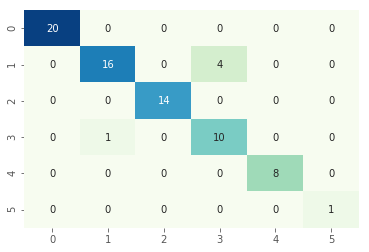

In [34]:
# Fit Logistic Features to all features
svc = SVC(kernel="linear")
svc.fit(X_resampled3, y_resampled3)

# Test accuracy
acc = accuracy_score(y_test, svc.predict(X_test))
print('Test Accuracy {}'.format(acc))

# Plot confusion matrix
cm = confusion_matrix(y_test, svc.predict(X_test))
sns.heatmap(cm, fmt='d', cmap='GnBu', cbar=False, annot=True)

C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of features selected: 237
Test Accuracy 0.9324324324324325


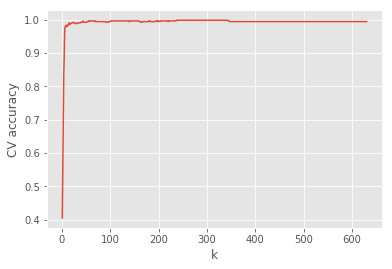

In [35]:
#==============================================================================
# Recursive Feature Selection
#==============================================================================

# RFE
rfe = RFECV(estimator=SVC(kernel="linear"), cv=4, scoring='accuracy')
rfe = rfe.fit(X_resampled3, y_resampled3)

# Select variables and calulate test accuracy
cols = X_resampled3.columns[rfe.support_]
acc = accuracy_score(y_test, rfe.estimator_.predict(X_test[cols]))
print('Number of features selected: {}'.format(rfe.n_features_))
print('Test Accuracy {}'.format(acc))

# Plot number of features vs CV scores
plt.figure()
plt.xlabel('k')
plt.ylabel('CV accuracy')
plt.plot(np.arange(1, rfe.grid_scores_.size+1), rfe.grid_scores_)
plt.show()

In [37]:
#==============================================================================
# Feature importances
#==============================================================================

# Feature importance values from Random Forests
rf = RandomForestClassifier(n_jobs=-1, random_state=SEED)
rf.fit(X_resampled3, y_resampled3)
feat_imp = rf.feature_importances_

# Select features and fit Logistic Regression
cols = X_resampled3.columns[feat_imp >= 0.01]
est_imp = SVC(kernel="linear")
est_imp.fit(X_resampled3[cols], y_resampled3)

# Test accuracy
acc = accuracy_score(y_test, est_imp.predict(X_test[cols]))
print('Number of features selected: {}'.format(len(cols)))
print('Test Accuracy {}'.format(acc))

C:\D\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\D\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


Number of features selected: 42
Test Accuracy 0.9594594594594594


C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
#==============================================================================
# Boruta
#==============================================================================

# Random Forests for Boruta 
rf_boruta = RandomForestClassifier(n_jobs=-1, random_state=SEED)
# Perform Boruta
boruta = BorutaPy(rf_boruta, n_estimators='auto', verbose=2)
boruta.fit(X_resampled3.values, y_resampled3.values.ravel())

# Select features and fit Logistic Regression
cols = X_resampled3.columns[boruta.support_]
est_boruta = SVC(kernel="linear")
est_boruta.fit(X_resampled3[cols], y_resampled3)

# Test accuracy
acc = accuracy_score(y_test, est_boruta.predict(X_test[cols]))
print('Number of features selected: {}'.format(len(cols)))
print('Test Accuracy {}'.format(acc))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	630
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	194
Tentative: 	174
Rejected: 	262
Iteration: 	9 / 100
Confirmed: 	194
Tentative: 	174
Rejected: 	262
Iteration: 	10 / 100
Confirmed: 	194
Tentative: 	174
Rejected: 	262
Iteration: 	11 / 100
Confirmed: 	194
Tentative: 	174
Rejected: 	262
Iteration: 	12 / 100
Confirmed: 	208
Tentative: 	160
Rejected: 	262
Iteration: 	13 / 100
Confirmed: 	208
Tentative: 	141
Rejected: 	281
Iteration: 	14 / 100
Confirmed: 	208
Tentative: 	141
Rejected: 	281
Iteration: 	15 / 100
Confirmed: 	208
Tentative: 	141
Rejected: 	281
Iteration: 	16 / 

C:\D\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
